#Start


In [1]:
# === STEP 1: Data Loading ===
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load all datasets
assessments = pd.read_csv('/content/drive/MyDrive/A_test/assessments.csv')
courses = pd.read_csv('/content/drive/MyDrive/A_test/courses.csv')
studentAssessment = pd.read_csv('/content/drive/MyDrive/A_test/studentAssessment.csv')
studentInfo = pd.read_csv('/content/drive/MyDrive/A_test/studentInfo.csv')
studentRegistration = pd.read_csv('/content/drive/MyDrive/A_test/studentRegistration.csv')
vle = pd.read_csv('/content/drive/MyDrive/A_test/vle.csv')
studentVle = pd.read_csv('/content/drive/MyDrive/A_test/studentVle.csv')

# === STEP 2: Data Integration ===
# Merge core student information
df = pd.merge(studentInfo, studentRegistration,
             on=['code_module','code_presentation','id_student'],
             how='left')

# Add course metadata
df = pd.merge(df, courses,
             on=['code_module','code_presentation'],
             how='left')

# Merge assessments data
course_assessments = pd.merge(courses, assessments,
                             on=['code_module','code_presentation'],
                             how='left')

df = pd.merge(df, course_assessments,
             on=['code_module','code_presentation'],
             suffixes=('', '_assessments'),
             how='left')

# Clean up merged columns
df['module_presentation_length'] = df['module_presentation_length_assessments']
df = df.drop(columns=['module_presentation_length_assessments'])

# Merge student assessment scores
df = pd.merge(df, studentAssessment,
             on=['id_assessment','id_student'],
             how='left')

# Merge VLE interactions
vle_interactions = pd.merge(vle, studentVle,
                           on=['id_site','code_module','code_presentation'],
                           how='inner')

vle_agg = vle_interactions.groupby(['code_module','code_presentation','id_student'])['sum_click'].sum().reset_index()
df = pd.merge(df, vle_agg,
             on=['code_module','code_presentation','id_student'],
             how='left')



In [2]:
# === STEP 3: Missing Value Handling ===
# Assessment scores and clicks
df['score'] = df['score'].fillna(0)  # 0 = no attempt
df['sum_click'] = df['sum_click'].fillna(0)  # 0 = no interaction

# Date features
df['date'] = df.groupby(['code_module','code_presentation'])['date'].transform(lambda x: x.fillna(x.median()))
df['date_submitted'] = df['date_submitted'].fillna(-1)  # Special value for missing submissions
df['is_banked'] = df['is_banked'].fillna(0).astype(int)

# Socioeconomic data
df['imd_band'] = df['imd_band'].fillna(df['imd_band'].mode()[0])

# Registration dates
df['date_registration'] = df.groupby(['code_module','code_presentation'])['date_registration'] \
                           .transform(lambda x: x.fillna(x.median()))


In [3]:
# === STEP 4: Feature Engineering ===
# Dropout flag
df['dropped_out'] = np.where(df['date_unregistration'].isna(), 0, 1)

# Temporal features
df['days_to_assessment'] = df['date'] - df['date_registration']
df['submission_delay'] = np.where(
    df['date_submitted'] == -1,
    -1,  # Special value for missing submissions
    df['date_submitted'] - df['date']
)

# Handle negative delays
df['submission_delay'] = np.where(df['submission_delay'] < 0, 0, df['submission_delay'])

# Frequency encoding for high-cardinality region
region_freq = df['region'].value_counts(normalize=True)
df['region_encoded'] = df['region'].map(region_freq)

In [4]:
# === STEP 5: Feature Selection ===
drop_cols = [
    'code_module', 'code_presentation', 'id_student',
    'id_assessment', 'date_unregistration', 'date',
    'date_submitted', 'date_registration', 'region',
    'assessment_type'
]
df_clean = df.drop(columns=drop_cols)

In [5]:
# === STEP 6: Categorical Encoding ===
cat_cols = ['gender', 'highest_education', 'imd_band',
           'age_band', 'disability', 'final_result']
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)


In [6]:

# === STEP 7: Proper Scaling ===
# Identify all numeric columns (including dummy variables)
numeric_cols = df_encoded.select_dtypes(include=np.number).columns.tolist()

# Scale ALL features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded[numeric_cols])


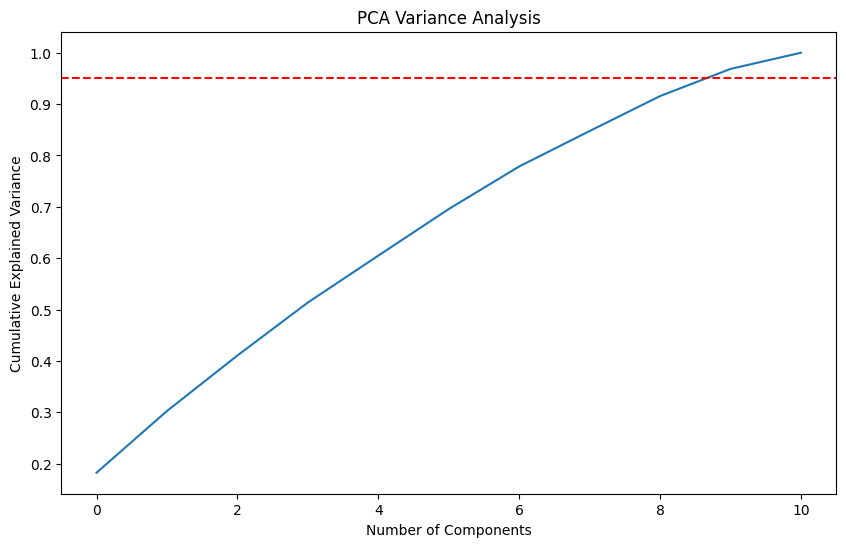

In [7]:
# === STEP 8: PCA Implementation ===
# Fit PCA with variance analysis
pca = PCA().fit(X_scaled)

# Plot explained variance
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(0.95, color='red', linestyle='--')
plt.title('PCA Variance Analysis')
plt.show()

In [8]:
# Choose components for 95% variance
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0] + 1
print(f"Components needed for 95% variance: {n_components}")

# Final PCA transform
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

print("\nFinal PCA Shape:", X_pca.shape)
print("Explained Variance:", np.cumsum(pca.explained_variance_ratio_))


Components needed for 95% variance: 10

Final PCA Shape: (323925, 10)
Explained Variance: [0.18237485 0.30251268 0.41057432 0.51371151 0.60503216 0.69573723
 0.77860481 0.84765063 0.91567643 0.96855338]


In [9]:
# === STEP 9: Result Interpretation ===
# Create loadings dataframe
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)],
    index=numeric_cols
)

# Show top features for first component
print("\nTop Features Driving PC1:")
print(loadings.abs().sort_values('PC1', ascending=False).head(5)['PC1'])



Top Features Driving PC1:
score              0.606407
dropped_out        0.545111
sum_click          0.469170
studied_credits    0.211576
weight             0.187395
Name: PC1, dtype: float64


In [10]:

# Save final results
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
pca_df.to_csv('/content/drive/MyDrive/A_test/final_pca_results.csv', index=False)
pca_df.shape

(323925, 10)

In [11]:
# Separate features & target BEFORE PCA
X = df.drop(columns=['final_result'])  # All preprocessed features
y = df['final_result']  # Target variable

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [12]:
# Use your 10 PCA components
from sklearn.ensemble import RandomForestClassifier

model_pca = RandomForestClassifier()
model_pca.fit(X_pca_train, y_train)  # X_pca from earlier

NameError: name 'X_pca_train' is not defined

#Strategy 1

In [14]:
# === STEP 1: Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# === STEP 2: Load Datasets ===
assessments = pd.read_csv('/content/drive/MyDrive/A_test/assessments.csv')
courses = pd.read_csv('/content/drive/MyDrive/A_test/courses.csv')
studentAssessment = pd.read_csv('/content/drive/MyDrive/A_test/studentAssessment.csv')
studentInfo = pd.read_csv('/content/drive/MyDrive/A_test/studentInfo.csv')
studentRegistration = pd.read_csv('/content/drive/MyDrive/A_test/studentRegistration.csv')
vle = pd.read_csv('/content/drive/MyDrive/A_test/vle.csv')
studentVle = pd.read_csv('/content/drive/MyDrive/A_test/studentVle.csv')


In [15]:

# === STEP 3: Merge Core Tables ===
df = pd.merge(studentInfo, studentRegistration, on=['code_module', 'code_presentation', 'id_student'], how='left')
df = pd.merge(df, courses, on=['code_module', 'code_presentation'], how='left')

# Merge assessments and scores
course_assessments = pd.merge(courses, assessments, on=['code_module', 'code_presentation'], how='left')
df = pd.merge(df, course_assessments, on=['code_module', 'code_presentation'], how='left', suffixes=('', '_assessments'))
df['module_presentation_length'] = df['module_presentation_length_assessments']
df = df.drop(columns=['module_presentation_length_assessments'])

df = pd.merge(df, studentAssessment, on=['id_assessment', 'id_student'], how='left')

# VLE interactions
vle_interactions = pd.merge(vle, studentVle, on=['id_site', 'code_module', 'code_presentation'], how='inner')
vle_agg = vle_interactions.groupby(['code_module', 'code_presentation', 'id_student'])['sum_click'].sum().reset_index()
df = pd.merge(df, vle_agg, on=['code_module', 'code_presentation', 'id_student'], how='left')


In [16]:

# === STEP 4: Handle Missing Values ===
df['score'] = df['score'].fillna(0)
df['sum_click'] = df['sum_click'].fillna(0)
df['date'] = df.groupby(['code_module','code_presentation'])['date'].transform(lambda x: x.fillna(x.median()))
df['date_submitted'] = df['date_submitted'].fillna(-1)
df['is_banked'] = df['is_banked'].fillna(0).astype(int)
df['imd_band'] = df['imd_band'].fillna(df['imd_band'].mode()[0])
df['date_registration'] = df.groupby(['code_module','code_presentation'])['date_registration'].transform(lambda x: x.fillna(x.median()))

# === STEP 5: Feature Engineering ===
df['dropped_out'] = np.where(df['date_unregistration'].isna(), 0, 1)
df['days_to_assessment'] = df['date'] - df['date_registration']
df['submission_delay'] = np.where(df['date_submitted'] == -1, -1, df['date_submitted'] - df['date'])
df['submission_delay'] = np.where(df['submission_delay'] < 0, 0, df['submission_delay'])

# Frequency encode region
region_freq = df['region'].value_counts(normalize=True)
df['region_encoded'] = df['region'].map(region_freq)



In [17]:
# === STEP 6: Drop Unneeded Columns ===
drop_cols = [
    'code_module', 'code_presentation', 'id_student', 'id_assessment',
    'date_unregistration', 'date', 'date_submitted', 'date_registration',
    'region', 'assessment_type'
]
df_clean = df.drop(columns=drop_cols)

# === STEP 7: Encode Categorical Variables ===
target = df_clean['final_result']
df_clean = df_clean.drop(columns=['final_result'])  # Exclude from features for PCA

cat_cols = ['gender', 'highest_education', 'imd_band', 'age_band', 'disability']
df_encoded = pd.get_dummies(df_clean, columns=cat_cols, drop_first=True)


In [18]:
# === STEP 8: Scaling ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# === STEP 9: PCA for Dimensionality Reduction ===
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA reduced shape: {X_pca.shape}")


PCA reduced shape: (323925, 25)


In [23]:
# === STEP 10: Prepare Labels ===
y = target.map({'Fail': 0, 'Withdrawn': 1, 'Pass': 2, 'Distinction': 3})  # You can adjust as needed

# === STEP 11: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)


In [24]:
# === STEP 12: Classification Model (Logistic Regression Example) ===
model = LogisticRegression(max_iter=10)
model.fit(X_train, y_train)

# === STEP 13: Evaluation ===
y_pred = model.predict(X_test)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fail', 'Withdrawn', 'Pass', 'Distinction']))



Confusion Matrix:
[[ 9496   327  4554    15]
 [  674 19497    69     2]
 [ 2460    17 21381   334]
 [  240     2  5385   332]]

Classification Report:
              precision    recall  f1-score   support

        Fail       0.74      0.66      0.70     14392
   Withdrawn       0.98      0.96      0.97     20242
        Pass       0.68      0.88      0.77     24192
 Distinction       0.49      0.06      0.10      5959

    accuracy                           0.78     64785
   macro avg       0.72      0.64      0.63     64785
weighted avg       0.77      0.78      0.76     64785



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
# === STEP 14: Save PCA Output (Optional) ===
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['final_result'] = y.values
pca_df.to_csv('/content/drive/MyDrive/A_test/final_pca_with_labels.csv', index=False)


In [26]:
# prompt: apply XGBoost	LightGBM Stacked Ensemble

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Assuming X_train, X_test, y_train, y_test are already defined from previous code

# Define base models
xgb_model = xgb.XGBClassifier(random_state=42)
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define meta-learner
meta_learner = LogisticRegression()

# Create StackingClassifier
stacking_model = StackingClassifier(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model)],
    final_estimator=meta_learner,
    cv=5  # Adjust cross-validation folds as needed
)

# Train the stacked ensemble
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred = stacking_model.predict(X_test)

# Evaluate the model (using metrics from previous code)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fail', 'Withdrawn', 'Pass', 'Distinction']))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 259140, number of used features: 25
[LightGBM] [Info] Start training from score -1.504436
[LightGBM] [Info] Start training from score -1.163302
[LightGBM] [Info] Start training from score -0.985062
[LightGBM] [Info] Start training from score -2.386088


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 207312, number of used features: 25
[LightGBM] [Info] Start training from score -1.504432
[LightGBM] [Info] Start training from score -1.163305
[LightGBM] [Info] Start training from score -0.985070
[LightGBM] [Info] Start training from score -2.386056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 207312, number of used features: 25
[LightGBM] [Info] Start training from score -1.504432
[LightGBM] [Info] Start training from score -1.163305
[LightGBM] [Info] Start training from score -0.985057
[LightGBM] [Info] Start training from score -2.386108


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 207312, number of used features: 25
[LightGBM] [Info] Start training from score -1.504432
[LightGBM] [Info] Start training from score -1.163305
[LightGBM] [Info] Start training from score -0.985057
[LightGBM] [Info] Start training from score -2.386108


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 207312, number of used features: 25
[LightGBM] [Info] Start training from score -1.504432
[LightGBM] [Info] Start training from score -1.163305
[LightGBM] [Info] Start training from score -0.985057
[LightGBM] [Info] Start training from score -2.386108


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6375
[LightGBM] [Info] Number of data points in the train set: 207312, number of used features: 25
[LightGBM] [Info] Start training from score -1.504454
[LightGBM] [Info] Start training from score -1.163290
[LightGBM] [Info] Start training from score -0.985070
[LightGBM] [Info] Start training from score -2.386056


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Confusion Matrix:
[[10137    63  4110    82]
 [  149 20036    56     1]
 [ 1999    11 21323   859]
 [  211     3  3646  2099]]

Classification Report:
              precision    recall  f1-score   support

        Fail       0.81      0.70      0.75     14392
   Withdrawn       1.00      0.99      0.99     20242
        Pass       0.73      0.88      0.80     24192
 Distinction       0.69      0.35      0.47      5959

    accuracy                           0.83     64785
   macro avg       0.81      0.73      0.75     64785
weighted avg       0.83      0.83      0.82     64785



# Strategy 2

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# Models & Imbalance Handling
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

# Save Model
import joblib


2. Data Loading & Merging


In [2]:
# Load All CSV Files
def load_data(base_path='/content/drive/MyDrive/A_test/'):
    return {
        'assessments': pd.read_csv(f'{base_path}assessments.csv'),
        'courses': pd.read_csv(f'{base_path}courses.csv'),
        'studentAssessment': pd.read_csv(f'{base_path}studentAssessment.csv'),
        'studentInfo': pd.read_csv(f'{base_path}studentInfo.csv'),
        'studentRegistration': pd.read_csv(f'{base_path}studentRegistration.csv'),
        'vle': pd.read_csv(f'{base_path}vle.csv'),
        'studentVle': pd.read_csv(f'{base_path}studentVle.csv')
    }

# Merge Tables
def merge_data(data):
    # Core student info
    df = pd.merge(data['studentInfo'], data['studentRegistration'],
                on=['code_module','code_presentation','id_student'], how='left')

    # Course metadata
    df = pd.merge(df, data['courses'],
                on=['code_module','code_presentation'], how='left')

    # Assessments
    course_assessments = pd.merge(data['courses'], data['assessments'],
                                on=['code_module','code_presentation'], how='left')
    df = pd.merge(df, course_assessments, on=['code_module','code_presentation'],
                suffixes=('', '_assessments'), how='left')
    df['module_presentation_length'] = df['module_presentation_length_assessments']
    df.drop(columns=['module_presentation_length_assessments'], inplace=True)

    # Student scores
    df = pd.merge(df, data['studentAssessment'],
                on=['id_assessment','id_student'], how='left')

    # VLE clicks
    vle_merged = pd.merge(data['vle'], data['studentVle'],
                        on=['id_site','code_module','code_presentation'], how='inner')
    vle_agg = vle_merged.groupby(['code_module','code_presentation','id_student'])['sum_click'].sum().reset_index()
    df = pd.merge(df, vle_agg, on=['code_module','code_presentation','id_student'], how='left')

    return df

# Execute
data = load_data()
df = merge_data(data)



In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.5 MB/s eta 0:00:00


3. Feature Engineering & Cleaning

In [4]:

from category_encoders import TargetEncoder
def preprocess(df):
    # Handle Missing Values
    df['score'] = df['score'].fillna(0)  # No attempt = 0
    df['sum_click'] = df['sum_click'].fillna(0)  # No interaction = 0
    df['imd_band'] = df['imd_band'].fillna(df['imd_band'].mode()[0])

    # Temporal Features
    df['date'] = df.groupby(['code_module','code_presentation'])['date'].transform(lambda x: x.fillna(x.median()))
    df['date_registration'] = df.groupby(['code_module','code_presentation'])['date_registration'].transform(lambda x: x.fillna(x.median()))

    # Feature Engineering
    df['dropped_out'] = np.where(df['date_unregistration'].isna(), 0, 1)
    df['days_to_assessment'] = df['date'] - df['date_registration']

    # Target Encoding for Region
    region_encoder = TargetEncoder()
    df['region_encoded'] = region_encoder.fit_transform(df['region'], df['final_result'])

    # Drop Irrelevant Columns
    df.drop(columns=[
        'code_module', 'code_presentation', 'id_student',
        'id_assessment', 'date_unregistration', 'date',
        'date_submitted', 'date_registration', 'region',
        'assessment_type'
    ], inplace=True)

    return df

df_clean = preprocess(df)

4. Target Encoding & Split

In [5]:
# Encode Target
le = LabelEncoder()
y = le.fit_transform(df_clean['final_result'])

# Features (Exclude Target)
X = df_clean.drop(columns=['final_result'])

# Stratified Split (Prevent Data Leakage)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

5. Handle Class Imbalance

In [7]:
# Check Imbalance
print("Class Distribution:", np.unique(y_train, return_counts=True))

# ----> 1. ENSURE ALL FEATURES ARE NUMERIC <----
# Convert all columns to numeric (if needed)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

# ----> 2. EXPLICIT ONE-HOT ENCODING <----
# List all categorical columns (even if they appear numeric)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)

# ----> 3. HANDLE NAN AFTER ENCODING <----
X_train_encoded = X_train_encoded.fillna(0)

# ----> 4. CONVERT TO NUMPY ARRAYS <----
X_train_np = X_train_encoded.to_numpy()
# y_train is already a NumPy array, no need to convert again
y_train_np = y_train

# ----> 5. APPLY SMOTE <----
if len(np.unique(y)) > 1 and (np.bincount(y).min() / np.bincount(y).max()) < 0.3:
    smote = SMOTE(random_state=42)
    try:
        X_train_res, y_train_res = smote.fit_resample(X_train_np, y_train_np)
        X_train = pd.DataFrame(X_train_res, columns=X_train_encoded.columns)
        y_train = pd.Series(y_train_res)
    except Exception as e:
        print(f"SMOTE Failed: {str(e)}")
        print("Debug Info:")
        print("X_train shape:", X_train_np.shape)
        print("NaN values in X:", np.isnan(X_train_np).sum())
        print("Unique y values:", np.unique(y_train_np))

Class Distribution: (array([0, 1, 2, 3]), array([23838, 57566, 96767, 80969]))


In [8]:
# === 1. Check Class Imbalance Properly ===
# Use y_train's distribution, not full y
unique_classes, class_counts = np.unique(y_train, return_counts=True)
print("Training Class Distribution:")
for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples ({count/len(y_train):.1%})")

# === 2. Convert y_train to Numpy Array Safely ===
y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train.copy()

# === 3. Revised SMOTE Application ===
if len(unique_classes) > 1:
    # Calculate imbalance ratio using TRAINING data
    minority_ratio = np.min(class_counts) / np.max(class_counts)
    print(f"\nMinority/Majority Ratio: {minority_ratio:.2f}")

    if minority_ratio < 0.3:
        print("Applying SMOTE...")
        try:
            # Ensure float32 dtype for SMOTE compatibility
            X_train_np = X_train_encoded.astype(np.float32).to_numpy()

            smote = SMOTE(random_state=42)
            X_train_res, y_train_res = smote.fit_resample(X_train_np, y_train_np)

            # Convert back to pandas
            X_train = pd.DataFrame(X_train_res, columns=X_train_encoded.columns)
            y_train = pd.Series(y_train_res, name='final_result')

            print("\nPost-SMOTE Class Distribution:")
            print(pd.Series(y_train).value_counts(normalize=True))
        except Exception as e:
            print(f"\nSMOTE Failed: {str(e)}")
            print("Debug Info:")
            print("- X_train NaN:", pd.DataFrame(X_train_np).isna().sum().sum())
            print("- X_train Inf:", np.isinf(X_train_np).sum())
            print("- y_train Unique:", np.unique(y_train_np))
    else:
        print("No SMOTE needed - class ratio > 0.3")
else:
    print("Only one class present - cannot apply SMOTE")

Training Class Distribution:
Class 0: 96767 samples (25.0%)
Class 1: 96767 samples (25.0%)
Class 2: 96767 samples (25.0%)
Class 3: 96767 samples (25.0%)

Minority/Majority Ratio: 1.00
No SMOTE needed - class ratio > 0.3


In [9]:
# Pipeline 1: PCA + Random Forest
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Variance-based
    ('classifier', RandomForestClassifier(class_weight='balanced'))
])

# Pipeline 2: XGBoost (Raw Features)
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False,
        tree_method='gpu_hist'  # Enable GPU acceleration
    ))
])

In [10]:
# Parameter Grids
param_grid_pca = {
    'classifier__n_estimators': [10, 20],
    'classifier__max_depth': [None, 10],
    'pca__n_components': [10, 15]
}

param_grid_xgb = {
    'classifier__learning_rate': [0.1, 0.01],
    'classifier__max_depth': [3, 5],
    'classifier__n_estimators': [10, 20]
}

# Grid Search
pca_search = GridSearchCV(pca_pipeline, param_grid_pca, cv=3, n_jobs=-1, verbose=2)
xgb_search = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

# Train Models
pca_search.fit(X_train, y_train)
xgb_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:51:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      impor...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.1, 0.01],
                         'classifier__max_depth': [3, 5],
                         'classifier__n_estimators': [10, 20]},
             verbose=2)

In [12]:
def full_evaluation(model, X_test, y_test):
    # ----> 1. APPLY PREPROCESSING TO X_test <----
    X_test_preprocessed = X_test.apply(pd.to_numeric, errors='coerce')  # Numerical conversion
    X_test_preprocessed = pd.get_dummies(X_test_preprocessed, columns=cat_cols, drop_first=True)  # One-hot encoding
    X_test_preprocessed = X_test_preprocessed.fillna(0)  # Fill NaN

    y_pred = model.predict(X_test_preprocessed)  # Predict on preprocessed data

    # Metrics
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title('Confusion Matrix')
    plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


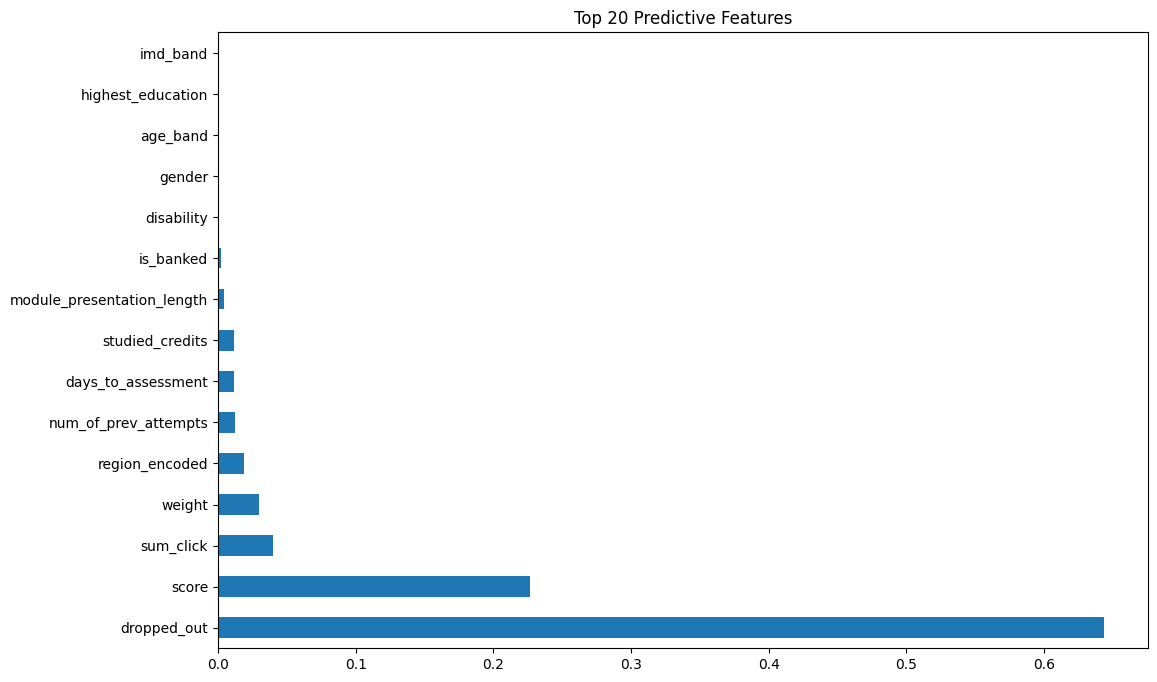

In [13]:
# Get XGBoost Feature Importances
importances = xgb_search.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = X.columns

# Plot Top 20
plt.figure(figsize=(12,8))
pd.Series(importances, index=feature_names).sort_values(ascending=False)[:20].plot.barh()
plt.title('Top 20 Predictive Features')
plt.show()

PCA + Random Forest:
Balanced Accuracy: 0.7790918516882938
              precision    recall  f1-score   support

 Distinction       0.46      0.63      0.53      5959
        Fail       0.77      0.78      0.77     14392
        Pass       0.79      0.71      0.75     24192
   Withdrawn       1.00      0.99      1.00     20242

    accuracy                           0.81     64785
   macro avg       0.75      0.78      0.76     64785
weighted avg       0.82      0.81      0.81     64785



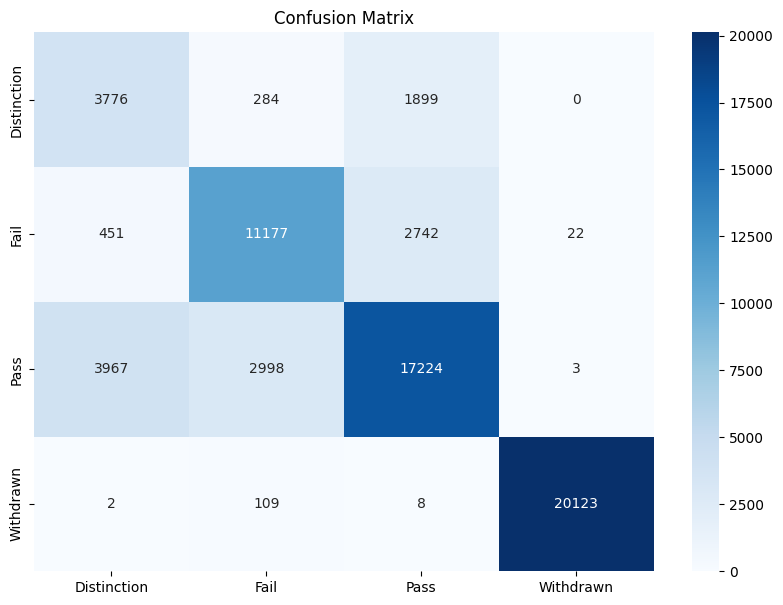


XGBoost:


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:00:33] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Balanced Accuracy: 0.744238255369769
              precision    recall  f1-score   support

 Distinction       0.34      0.69      0.45      5959
        Fail       0.73      0.74      0.73     14392
        Pass       0.75      0.55      0.64     24192
   Withdrawn       1.00      0.99      1.00     20242

    accuracy                           0.74     64785
   macro avg       0.70      0.74      0.70     64785
weighted avg       0.79      0.74      0.75     64785



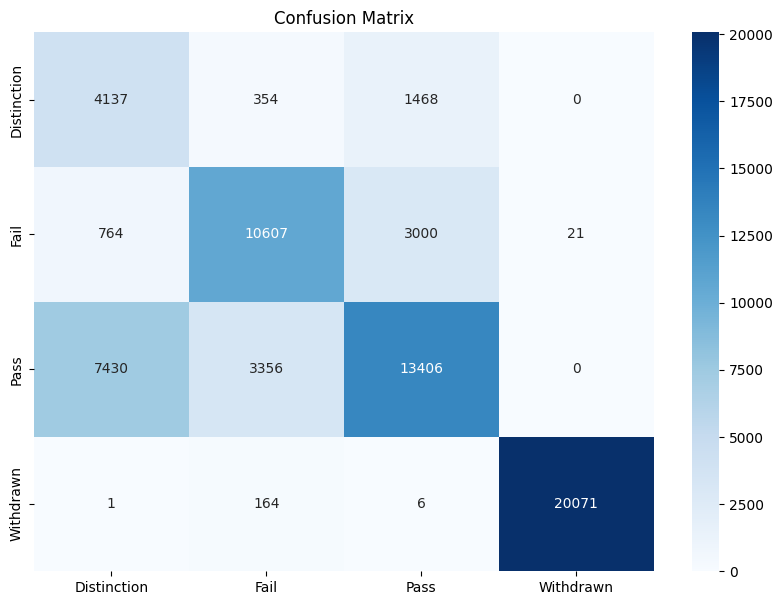

In [14]:
# prompt: check acuracy

# Evaluate the best models
print("PCA + Random Forest:")
full_evaluation(pca_search.best_estimator_, X_test, y_test)

print("\nXGBoost:")
full_evaluation(xgb_search.best_estimator_, X_test, y_test)
